# Lab Assignment 4

**Computer Vision** - Term 5, 2023

Instructor: Dr. Saumya Jetley <br>
TA: Ribhu Lahiri, Raghav Awasty


### Before Starting

Please download the FER-2013 dataset using the cell below

You will need it for the tasks that follow.

In [2]:
import gdown

!gdown "1uFKf3RHcYZVFHaejNMmz_lBgICIZf5VH&confirm=t" -O 'fer2013.zip'

Downloading...
From: https://drive.google.com/uc?id=1uFKf3RHcYZVFHaejNMmz_lBgICIZf5VH&confirm=t
To: /content/fer2013.zip
100% 101M/101M [00:01<00:00, 94.8MB/s] 


In [3]:
! unzip fer2013.zip

Archive:  fer2013.zip
  inflating: fer2013.csv             


In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from skimage import color
from skimage.transform import resize
from skimage.feature import hog

In [5]:
# Reading in the dataset
df = pd.read_csv('./fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
# Extract relevant data
x_data = pd.Series(df.pixels)
y_data = pd.Series(df.emotion)
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255 # Normalizing

In [7]:
# Reshape into 48x48 images
x_data = x_data.reshape(-1, 48, 48)
x_data.shape

(35887, 48, 48)

### Task 1: Creating histogram of Oriented Gradients (4 points)
The first task is to create the histogram of oriented gradients feature descriptor. There are two steps to it, the first is to create the oriented gradients from a given image which returns the magnitude and angle matrices. The next step then, is to use those matrices to create the histogram features.

You can refer to this blog as discussed in the lab session: https://iq.opengenus.org/object-detection-with-histogram-of-oriented-gradients-hog/

**Implement the `get_oriented_gradients` function** *(2 points)*

Use any sample image from the dataset to test out your function

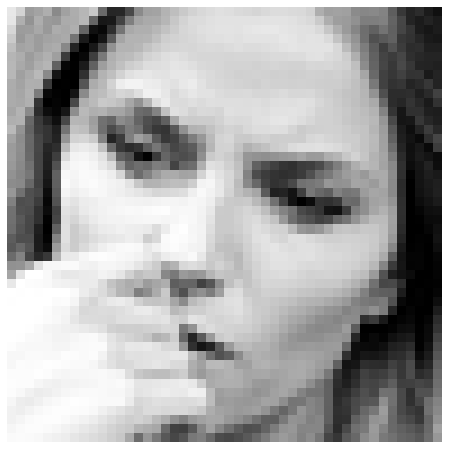

In [8]:
# Read in any image from the dataset
img = x_data[2]
plt.figure(figsize=(15, 8))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [9]:
# Task: 

def window(receptive_field, filter):
    ''' 
    Convolves a filter over the receptive field from the image

    Parameters
    ----------
    receptive_field: np.ndarray
        The portion of the image the convolution is being done over

    filter: np.ndarray
        The defined filter

    Returns
    -------
    np.ndarray
        The convolved receptive field output
    '''
  
    return np.sum(filter * receptive_field)
    
def convolve(image, kernel):
    ''' 
    Convolves the filter over the image (sliding window)

    Parameters
    ----------
    image: np.ndarray
        The image as a 2-dimensional matrix

    kernel: np.ndarray
        The defined filter

    Returns
    -------
    output_image: np.ndarray
        The image after convolving the filter over it
    '''

    # Here I am doing the convolution with the zero padding to preseve the image shape

    #step1:  zero pad the input image: Assuming both image and kernal are square shaped
    pw = kernel.shape[0]//2  
    shape = image.shape

    image = np.pad(image, pad_width = pw, mode = "constant")

    #step2: initialize the output:
    output = np.zeros(shape)

    #step 3: interatively convolve:
    for i in range(pw,shape[0]+pw):
      for j in range(pw,shape[1]+pw):
        output[i-pw,j-pw] = window(image[i-pw:i+pw+1,j-pw:j+pw+1],kernel)
    
    return output    

In [10]:
img = np.array(img)
def get_oriented_gradients(img):
  '''
    Returns the magnitude and angles of the oriented gradients
    from the given image

    Parameters
    ----------
    img: np.ndarray
        The given image

    Returns
    -------
    mag: np.ndarray
        2-D Numpy array that contains the magnitudes of the oriented gradients

    theta: np.ndarray
        2-D Numpy array that contains the angles of the oriented gradients
  '''
  # Sobel filters
  sobel_x = np.array([[-1, 0, 1], 
                      [-2, 0, 2], 
                      [-1, 0, 1]])

  sobel_y = np.array([[-1, -2, -1], 
                      [0, 0, 0], 
                      [1, 2, 1]])

  # gaussian_1d = np.array([1, 2, 1],np.float32)
  # x_derivative = np.array([-1, 0, 1],np.float32)
  # s_x = np.outer(gaussian_1d, x_derivative)  
  # s_y = np.outer(x_derivative, gaussian_1d)

  filtered_v = convolve(img, sobel_x)
  filtered_h = convolve(img, sobel_y)

  mag   =  np.sqrt(filtered_h**2 + filtered_v**2)
  m = mag.max()
  if m!=0:
    mag = mag/m
    
  theta = np.rad2deg(np.arctan2(filtered_v, filtered_h))
  theta = theta%180 
  return mag,theta

In [11]:
mag, theta = get_oriented_gradients(img)

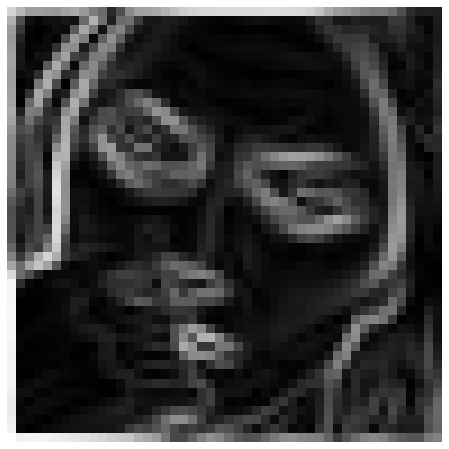

In [12]:
plt.figure(figsize=(15, 8))
plt.imshow(mag, cmap="gray")
plt.axis("off")
plt.show()

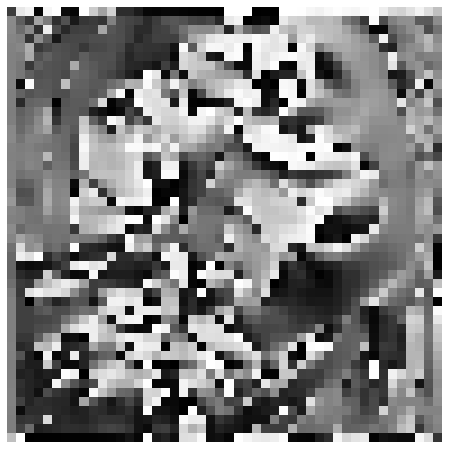

In [13]:
plt.figure(figsize=(15, 8))
plt.imshow(theta, cmap="gray")
plt.axis("off")
plt.show()

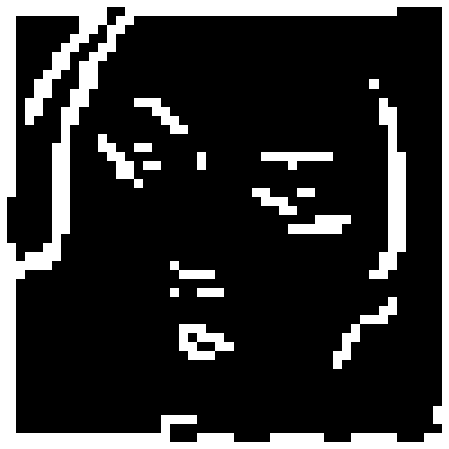

In [37]:
m_viz = (mag > 0.4).astype(float)
plt.figure(figsize=(15, 8))
plt.imshow(m_viz, cmap="gray")
plt.axis("off")
plt.show()

**Implement the `hog_features` function** *(2 points)*

Use the image, magnitudes, and angles of oriented gradients to bin them and create the HoG features to be used by our classifier

NOTE: While I have set the default value of number of bins as 9. Feel free to experiment and observe the effects of changing it on the downstream task

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [16]:
def helper(grad,angles):
  out = np.zeros(9)
  for i in range(grad.shape[0]):
    for j in range(grad.shape[1]):
      o      = angles[i,j]//20
      out[int(o)]+=grad[i,j]
  return out  



In [17]:
def hog_features(img):
  '''
    Create the histogram of oriented gradients feature vector

    Parameters
    ----------
    img: np.ndarray
        The given image

    nbins: int
        The number of buckets (bins) in which to organise the oriented gradients

    mag: np.ndarray
        2-D Numpy array that contains the magnitudes of the oriented gradients

    theta: np.ndarray
        2-D Numpy array that contains the angles of the oriented gradients

    Returns
    -------
    np.ndarray
        The HoG features 
        [given input of 48x48 images, 8x8 cells with 9 bins, 
         and 16x16 normalized blocks should be 1296:
            6 moves in the x-direction
            6 moves in the y-direction
             6*12*9 -->648]
  '''
  # nbins = 9

  mag,theta = get_oriented_gradients(img)

  histograms = []
  for i in range(6):
    for j in range(6):
      grad   = mag[i*8:(i+1)*8,j*8:(j+1)*8]
      angles = theta[i*8:(i+1)*8,j*8:(j+1)*8]
      histograms.append(helper(grad,angles))
  histograms = np.array(histograms).flatten()

  #normalizing the histogram for every 16*16 patch --> every 36 elements
  temp = histograms
  for i in range(9):
    m =  histograms[i*36 :(i+1)*36].max()
    if m==0:
      continue
    histograms[i*36 :(i+1)*36] = histograms[i*36 :(i+1)*36]/m
  return histograms

Trying it out on the image

In [18]:
hist_image = hog_features(img)

In [19]:
hist_image.shape

(324,)

### Task 2: Using HoG with AdaBoost Classifier (1 points)
The second task is to create an AdaBoost classifier that uses the HoG features to classify the given images into one of 7 classes representing different emotions.

**Extra Credit:** Implement the AdaBoost Classifier from scratch, i.e. without using scikit-learn (1 points)

**Right now I dont have the resources to run the model for long. So I am only taking the first 5000 images from train and 500 images from test.**

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                    test_size=0.3, 
                                                    random_state=42)
X_train.shape

(25120, 48, 48)

In [29]:
X_train = np.array([hog_features(im) for im in X_train[:5000]])
X_test = np.array([hog_features(im) for im in X_test[:500]])

In [30]:
X_train.shape

(5000, 324)

In [31]:
y_train = y_train[:5000]
y_test = y_test[:500]

In [32]:
from sklearn.ensemble import AdaBoostClassifier

In [33]:
# TODO
clf =  AdaBoostClassifier()
clf.fit(X_train, y_train)

AdaBoostClassifier()

In [34]:
from sklearn.metrics import classification_report

y_pred_train = clf.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.30      0.11      0.16       687
           1       0.23      0.15      0.18        68
           2       0.27      0.14      0.18       684
           3       0.38      0.71      0.49      1255
           4       0.31      0.19      0.23       870
           5       0.29      0.37      0.32       583
           6       0.27      0.24      0.26       853

    accuracy                           0.33      5000
   macro avg       0.29      0.27      0.26      5000
weighted avg       0.31      0.33      0.29      5000



In [35]:
y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.28      0.07      0.12        67
           1       0.00      0.00      0.00         6
           2       0.23      0.08      0.12        83
           3       0.38      0.69      0.49       126
           4       0.21      0.16      0.18        74
           5       0.23      0.25      0.24        59
           6       0.24      0.27      0.25        85

    accuracy                           0.30       500
   macro avg       0.22      0.22      0.20       500
weighted avg       0.27      0.30      0.26       500



As we can see above, even though i only took a subset of the training and test dataset, the accuracy I got was **30%** which is better than the random choice which is around 15%. 